In [4]:
import numpy as np
from skimage import io, img_as_float
from sklearn.feature_extraction import image
from sklearn.decomposition import MiniBatchDictionaryLearning
import matplotlib.pyplot as plt

# Load the image
image_original = img_as_float(io.imread('lena.png', as_gray=True))


SNR: 22.77 dB


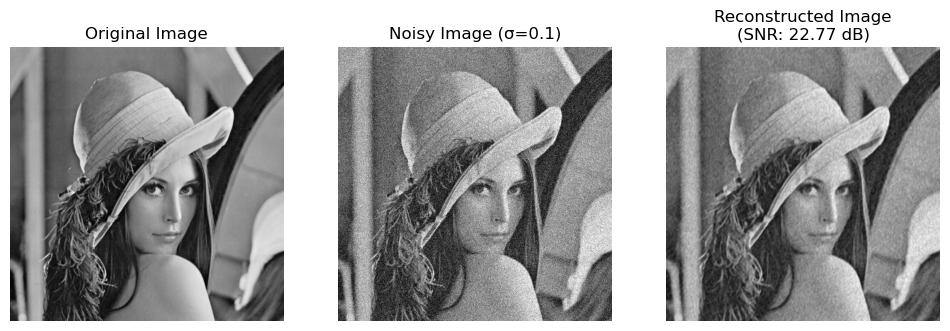

In [6]:
sigma = 0.1  # Standard deviation of the noise
noisy_image = image_original + sigma * np.random.randn(*image_original.shape)
noisy_image = np.clip(noisy_image, 0, 1)  # Ensure pixel values are in [0, 1]

patch_size = (7, 7)  # Size of patches
patches = image.extract_patches_2d(noisy_image, patch_size)
patches = patches.reshape(patches.shape[0], -1)  # Flatten patches

n_components = 100  # Number of dictionary atoms
dict_learner = MiniBatchDictionaryLearning(n_components=n_components, transform_algorithm='omp', transform_n_nonzero_coefs=3, random_state=0)
dictionary = dict_learner.fit(patches).components_

code = dict_learner.transform(patches)
patches_reconstructed = np.dot(code, dictionary)
patches_reconstructed = patches_reconstructed.reshape(len(patches), *patch_size)
reconstructed_image = image.reconstruct_from_patches_2d(patches_reconstructed, image_original.shape)

signal_power = np.sum(image_original ** 2)
noise_power = np.sum((image_original - reconstructed_image) ** 2)
snr = 10 * np.log10(signal_power / noise_power)
print(f'SNR: {snr:.2f} dB')

plt.figure(figsize=(12, 6))
plt.subplot(1, 3, 1)
plt.imshow(image_original, cmap='gray')
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(noisy_image, cmap='gray')
plt.title(f'Noisy Image (σ={sigma})')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(reconstructed_image, cmap='gray')
plt.title(f'Reconstructed Image\n(SNR: {snr:.2f} dB)')
plt.axis('off')

plt.show()



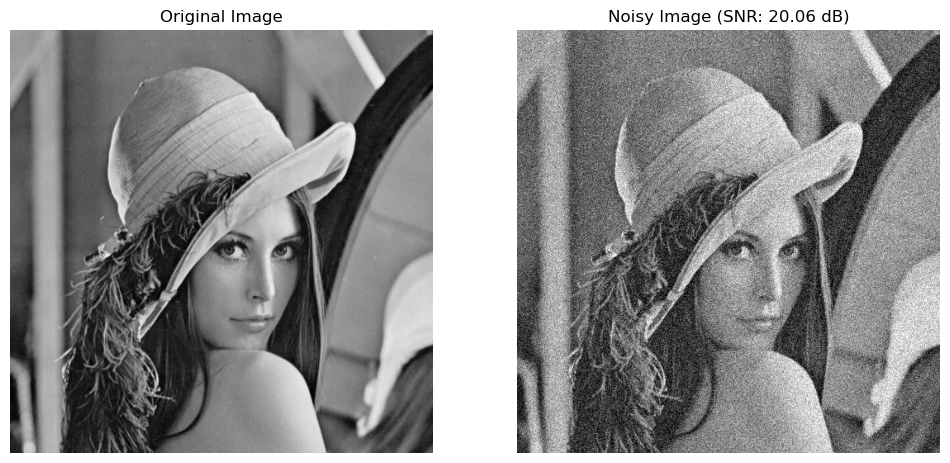

SNR of noisy image: 20.06 dB


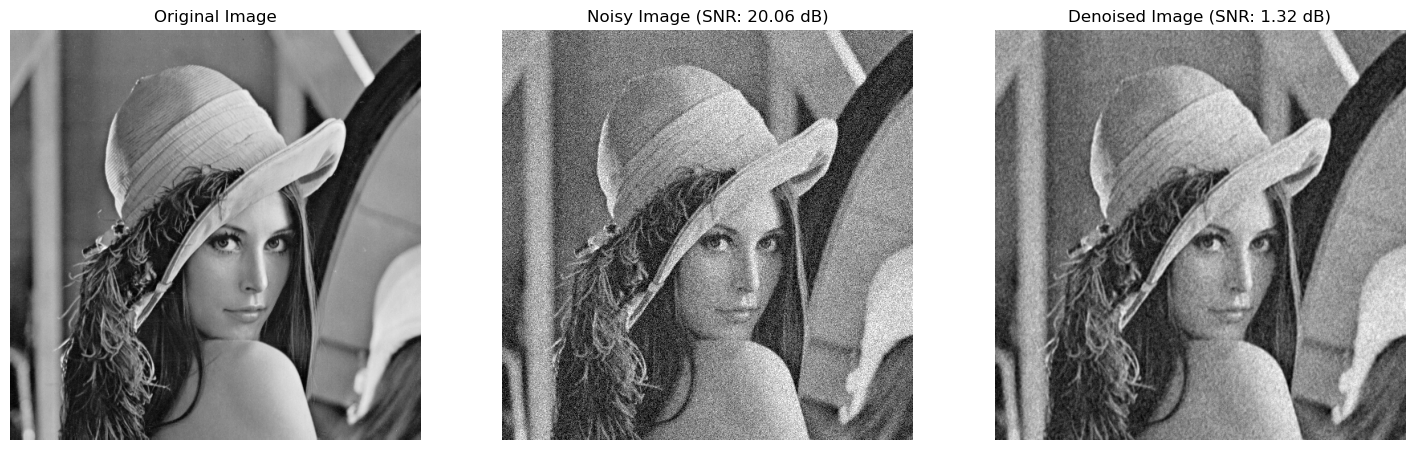

SNR of denoised image: 1.32 dB
Top 5 parameter combinations:
1. Patch Size: 4, n_components: 50, alpha: 0.5, max_iter: 50, SNR: 2.10 dB
2. Patch Size: 4, n_components: 50, alpha: 0.5, max_iter: 100, SNR: 1.95 dB
3. Patch Size: 4, n_components: 100, alpha: 0.5, max_iter: 50, SNR: 1.79 dB
4. Patch Size: 4, n_components: 50, alpha: 1.0, max_iter: 100, SNR: 1.76 dB
5. Patch Size: 4, n_components: 50, alpha: 1.0, max_iter: 50, SNR: 1.73 dB

Best parameters:
Patch Size: 4
n_components: 50
alpha: 0.5
max_iter: 50
Best SNR: 2.10 dB


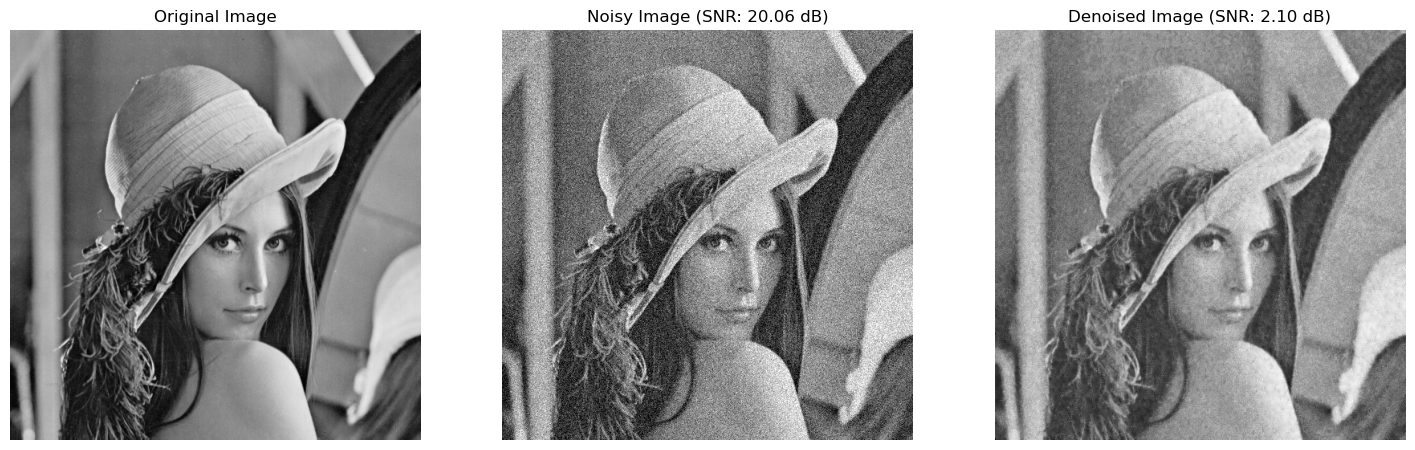

In [13]:
import numpy as np
from skimage import io, img_as_float
from sklearn.feature_extraction import image
from sklearn.decomposition import MiniBatchDictionaryLearning
import matplotlib.pyplot as plt
from skimage.metrics import peak_signal_noise_ratio

# Load the image
image_original = img_as_float(io.imread('lena.png', as_gray=True))

# Add normally distributed random noise
def add_noise(image, std_dev):
    noise = np.random.normal(0, std_dev, image.shape)
    noisy_image = image + noise
    return np.clip(noisy_image, 0, 1)

# Set noise level
noise_level = 0.1
noisy_image = add_noise(image_original, noise_level)

# Function to calculate SNR
def calculate_snr(original, noisy):
    return peak_signal_noise_ratio(original, noisy)

# Display original and noisy images
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(image_original, cmap='gray')
plt.title('Original Image')
plt.axis('off')
plt.subplot(122)
plt.imshow(noisy_image, cmap='gray')
plt.title(f'Noisy Image (SNR: {calculate_snr(image_original, noisy_image):.2f} dB)')
plt.axis('off')
plt.show()

print(f"SNR of noisy image: {calculate_snr(image_original, noisy_image):.2f} dB")

def denoise_image(noisy_image, patch_size, n_components, alpha, max_iter):
    # Extract patches from the noisy image
    patches = image.extract_patches_2d(noisy_image, (patch_size, patch_size))
    patches = patches.reshape(patches.shape[0], -1)
    patches -= np.mean(patches, axis=0)
    patches /= np.std(patches, axis=0)

    # Learn the dictionary
    dico = MiniBatchDictionaryLearning(n_components=n_components, alpha=alpha, max_iter=max_iter)
    dictionary = dico.fit(patches).components_

    # Sparse coding
    code = dico.transform(patches)
    
    # Reconstruct patches
    reconstructed_patches = np.dot(code, dictionary)
    
    # Add back the mean
    reconstructed_patches += np.mean(patches, axis=0)
    
    # Reshape patches
    reconstructed_patches = reconstructed_patches.reshape((-1, patch_size, patch_size))
    
    # Reconstruct the image from patches
    reconstructed_image = image.reconstruct_from_patches_2d(reconstructed_patches, noisy_image.shape)
    
    return reconstructed_image

# Set initial parameters
patch_size = 8
n_components = 100
alpha = 1.0
max_iter = 50

# Denoise the image
denoised_image = denoise_image(noisy_image, patch_size, n_components, alpha, max_iter)

# Calculate SNR
snr_denoised = calculate_snr(image_original, denoised_image)

# Display results
plt.figure(figsize=(18, 6))
plt.subplot(131)
plt.imshow(image_original, cmap='gray')
plt.title('Original Image')
plt.axis('off')
plt.subplot(132)
plt.imshow(noisy_image, cmap='gray')
plt.title(f'Noisy Image (SNR: {calculate_snr(image_original, noisy_image):.2f} dB)')
plt.axis('off')
plt.subplot(133)
plt.imshow(denoised_image, cmap='gray')
plt.title(f'Denoised Image (SNR: {snr_denoised:.2f} dB)')
plt.axis('off')
plt.show()

print(f"SNR of denoised image: {snr_denoised:.2f} dB")

# Parameter ranges to test
patch_sizes = [4, 8, 12]
n_components_list = [50, 100, 200]
alphas = [0.5, 1.0, 1.5]
max_iter_list = [50, 100]  # Changed from n_steps_list to max_iter_list

best_snr = 0
best_params = {}

results = []

for patch_size in patch_sizes:
    for n_components in n_components_list:
        for alpha in alphas:
            for max_iter in max_iter_list:  # Changed from n_steps to max_iter
                denoised_image = denoise_image(noisy_image, patch_size, n_components, alpha, max_iter)
                snr = calculate_snr(image_original, denoised_image)
                
                results.append({
                    'patch_size': patch_size,
                    'n_components': n_components,
                    'alpha': alpha,
                    'max_iter': max_iter,  # Changed from n_steps to max_iter
                    'snr': snr
                })
                
                if snr > best_snr:
                    best_snr = snr
                    best_params = {
                        'patch_size': patch_size,
                        'n_components': n_components,
                        'alpha': alpha,
                        'max_iter': max_iter  # Changed from n_steps to max_iter
                    }

# Sort results by SNR
results.sort(key=lambda x: x['snr'], reverse=True)

# Print top 5 results
print("Top 5 parameter combinations:")
for i, result in enumerate(results[:5], 1):
    print(f"{i}. Patch Size: {result['patch_size']}, n_components: {result['n_components']}, "
          f"alpha: {result['alpha']}, max_iter: {result['max_iter']}, SNR: {result['snr']:.2f} dB")

print("\nBest parameters:")
print(f"Patch Size: {best_params['patch_size']}")
print(f"n_components: {best_params['n_components']}")
print(f"alpha: {best_params['alpha']}")
print(f"max_iter: {best_params['max_iter']}")
print(f"Best SNR: {best_snr:.2f} dB")

# Generate final denoised image with best parameters
final_denoised_image = denoise_image(noisy_image, best_params['patch_size'], best_params['n_components'], 
                                     best_params['alpha'], best_params['max_iter'])

# Display final results
plt.figure(figsize=(18, 6))
plt.subplot(131)
plt.imshow(image_original, cmap='gray')
plt.title('Original Image')
plt.axis('off')
plt.subplot(132)
plt.imshow(noisy_image, cmap='gray')
plt.title(f'Noisy Image (SNR: {calculate_snr(image_original, noisy_image):.2f} dB)')
plt.axis('off')
plt.subplot(133)
plt.imshow(final_denoised_image, cmap='gray')
plt.title(f'Denoised Image (SNR: {best_snr:.2f} dB)')
plt.axis('off')
plt.show()

1. Patch Size: 4, n_components: 50, alpha: 0.5, max_iter: 50, SNR: 2.10 dB
2. Patch Size: 4, n_components: 50, alpha: 0.5, max_iter: 100, SNR: 1.95 dB
3. Patch Size: 4, n_components: 100, alpha: 0.5, max_iter: 50, SNR: 1.79 dB


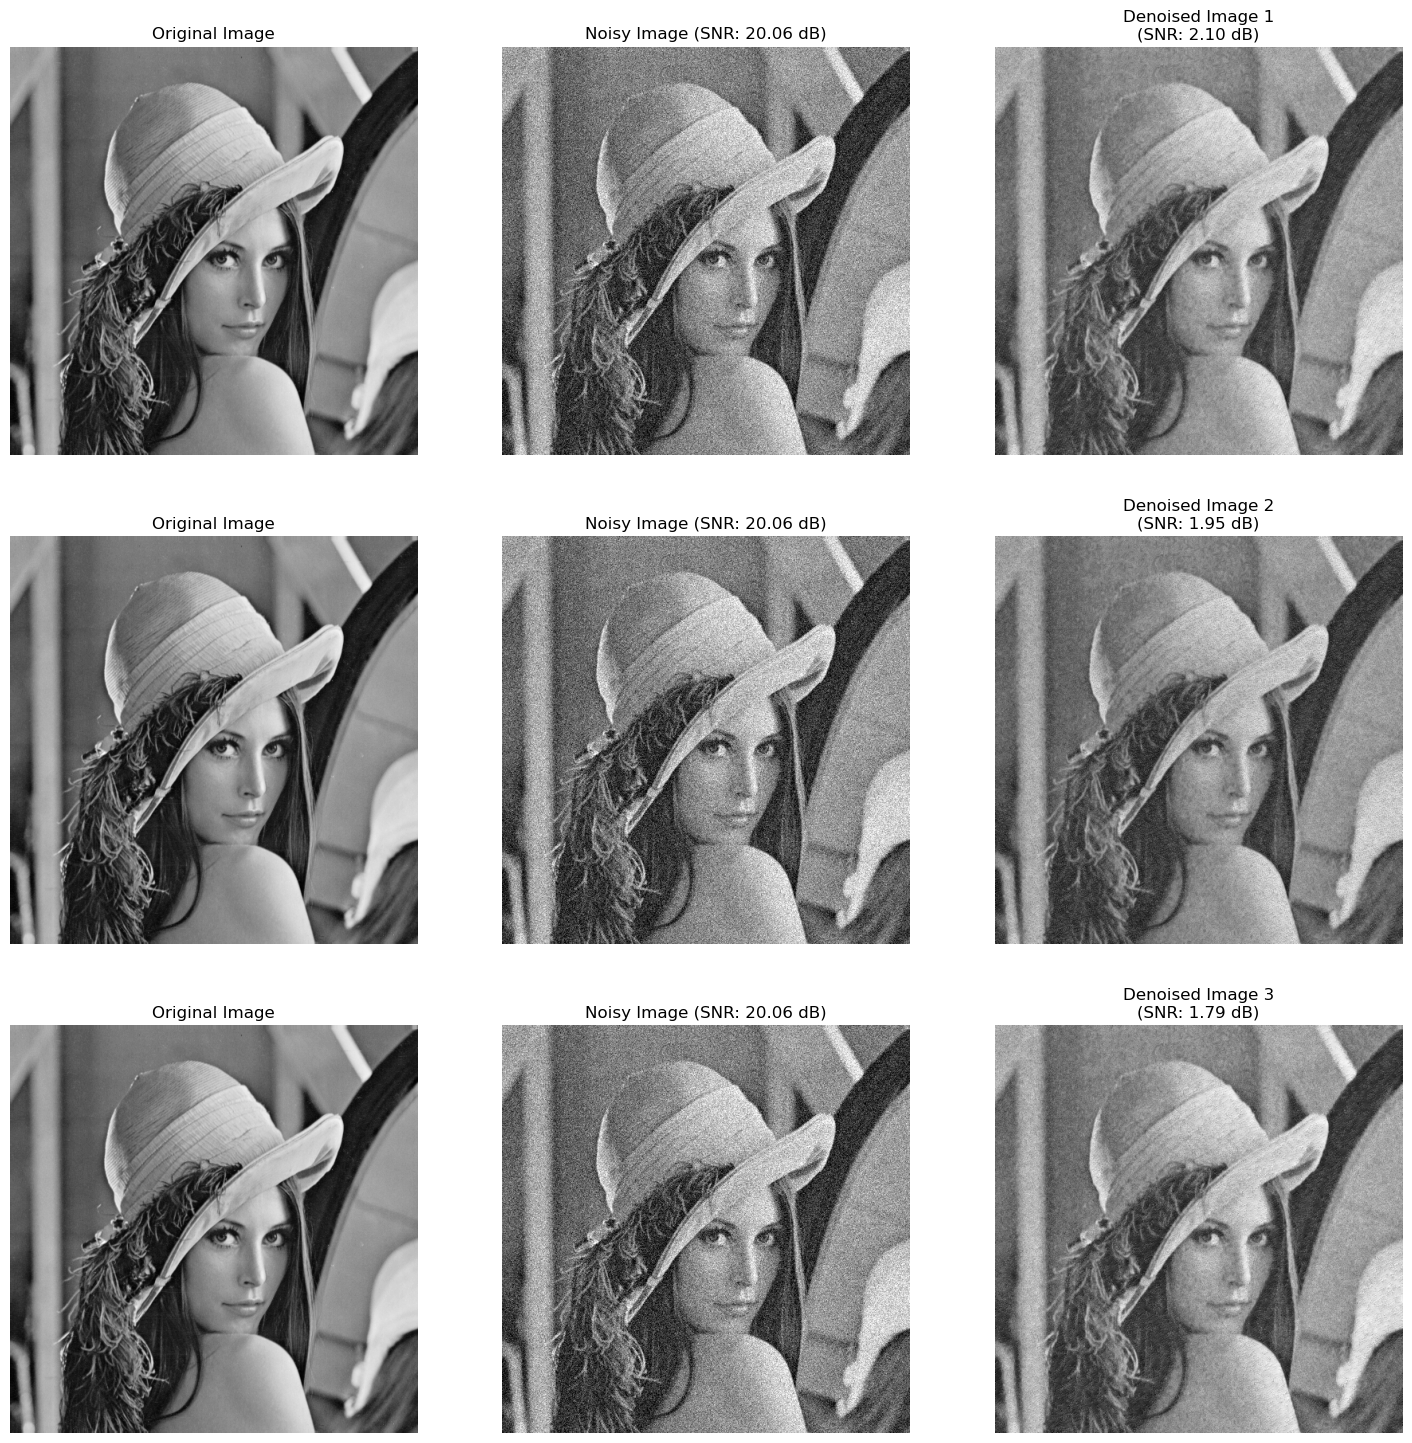

In [16]:
# Specify the number of top results you want to display
top_n = 3

# Sort results by SNR
results.sort(key=lambda x: x['snr'], reverse=True)

# Display the top N parameter combinations
for i, result in enumerate(results[:top_n], 1):
    print(f"{i}. Patch Size: {result['patch_size']}, n_components: {result['n_components']}, "
          f"alpha: {result['alpha']}, max_iter: {result['max_iter']}, SNR: {result['snr']:.2f} dB")

# Visualize the top N denoised images
plt.figure(figsize=(18, 6 * top_n))
for i, result in enumerate(results[:top_n], 1):
    denoised_image = denoise_image(noisy_image, result['patch_size'], result['n_components'], result['alpha'], result['max_iter'])
    
    plt.subplot(top_n, 3, 3*i-2)
    plt.imshow(image_original, cmap='gray')
    plt.title('Original Image')
    plt.axis('off')
    
    plt.subplot(top_n, 3, 3*i-1)
    plt.imshow(noisy_image, cmap='gray')
    plt.title(f'Noisy Image (SNR: {calculate_snr(image_original, noisy_image):.2f} dB)')
    plt.axis('off')
    
    plt.subplot(top_n, 3, 3*i)
    plt.imshow(denoised_image, cmap='gray')
    plt.title(f'Denoised Image {i}\n(SNR: {result["snr"]:.2f} dB)')
    plt.axis('off')

plt.show()
